
# Gravitational-Wave 1D Conv VAE

**Pipeline**

0. Installs (optional, for Colab)
1. Generate or Load Template Bank (SEOBNRv4 via PyCBC)
2. Prep Dataset / Dataloaders
3. Define 1D‑Conv VAE (PyTorch)
4. Train (ELBO = Recon MSE + β·KL) with Early‑Stopping + KL anneal
5. Evaluate: MSE, 1−NCC, (optional) self‑SNR proxy
6. Visualize reconstructions


In [ ]:

# --- Optional installs (for Colab) ---
# If you're in a fresh Colab environment, uncomment:
!pip install -U pip setuptools wheel
!pip install "numpy==2.0.2" "scipy==1.13.1" "matplotlib<3.9"
!pip install "cryptography<44" "pyopenssl<24.2.1"
!pip install torch --extra-index-url https://download.pytorch.org/whl/cpu
!pip install "pycbc==2.5.0" "tqdm"


In [12]:

import os, json, random, math, time
from dataclasses import dataclass, asdict
from typing import Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Optional (used in eval & bank synthesis):
try:
    from pycbc.waveform import get_td_waveform
    from pycbc.psd import aLIGOZeroDetHighPower
    from pycbc.filter import matched_filter
    from pycbc.types import TimeSeries
    PYCBC_OK = True
except Exception as _e:
    print("[WARN] PyCBC unavailable or failed to import. Synthesis/Eval involving SNR will be skipped.")
    PYCBC_OK = False

# --- Repro ---
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

@dataclass
class CFG:
    # Data / synthesis
    SR: int = 2048
    DUR: float = 2.0     # seconds
    FLOW: float = 20.0
    N_TOTAL: int = 3000  # total raw synth attempts
    #CAP: int = 1000      # cap after filtering (non-zero/finite rows)
    CAP = None
    MASS1_RANGE: Tuple[float,float] = (10.0, 50.0)
    MASS2_RANGE: Tuple[float,float] = (10.0, 50.0)
    SPIN_RANGE:  Tuple[float,float] = (0.0, 0.9)
    DIST: float = 400.0

    # Splits
    VAL_FRAC: float = 0.10
    TEST_FRAC: float = 0.15
    SEED: int = 42

    # Training
    BATCH: int = 64
    Z_DIM: int = 32
    LR: float = 2e-3
    EPOCHS: int = 100
    BETA_MAX: float = 1e-3      # KL weight cap
    BETA_WARMUP: int = 10       # epochs to reach BETA_MAX
    PATIENCE: int = 7           # early-stopping

    # Paths
    SAVE_DIR: str = "./"
    USE_DRIVE: bool = False     # ignored here but left for symmetry

cfg = CFG()
set_seed(cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


## 1) Bank Generation

In [15]:
def synth_one(cfg: CFG) -> Optional[np.ndarray]:
    """Return one standardized waveform, or None if generation fails."""
    if not PYCBC_OK:
        return None

    # sample params (same ranges as before)
    m1  = np.random.uniform(*cfg.MASS1_RANGE)
    m2  = np.random.uniform(*cfg.MASS2_RANGE)
    s1z = np.random.uniform(*cfg.SPIN_RANGE)
    s2z = np.random.uniform(*cfg.SPIN_RANGE)
    if m2 > m1:  # optional: enforce m1 >= m2
        m1, m2 = m2, m1

    # critical: don't crash on domain errors (e.g., ringdown > Nyquist)
    try:
        hp, _ = get_td_waveform(
            approximant="SEOBNRv4",
            mass1=m1, mass2=m2,
            spin1z=s1z, spin2z=s2z,
            delta_t=1/cfg.SR, f_lower=cfg.FLOW, distance=cfg.DIST
        )
    except Exception:
        return None  # failed draw -> skip

    x = hp.numpy().astype(np.float32)
    T = int(cfg.SR * cfg.DUR)
    if len(x) < T:
        x = np.pad(x, (T - len(x), 0))
    else:
        x = x[-T:]

    # per-sample standardization; if degenerate, skip
    s = float(x.std())
    if not np.isfinite(s) or s == 0.0:
        return None
    x = (x - float(x.mean())) / (s + 1e-6)
    return x


def build_bank(cfg: CFG, cache_path: str = "gw_bank.npz") -> np.ndarray:
    """Collect as many valid waveforms as requested; skip failures without crashing."""
    if os.path.exists(cache_path):
        data = np.load(cache_path)
        X = data["X"].astype(np.float32)
        print(f"[cache] Loaded bank from {cache_path} ->", X.shape)
        return X

    if not PYCBC_OK:
        raise RuntimeError("PyCBC not available; cannot synthesize bank. Provide a cached bank.")

    T = int(cfg.SR * cfg.DUR)
    target = cfg.CAP if (cfg.CAP is not None) else cfg.N_TOTAL
    X = np.zeros((target, T), dtype=np.float32)

    good, attempts = 0, 0
    max_attempts = int(3 * target)  # avoid infinite loops; raise this if you want

    from tqdm import tqdm
    pbar = tqdm(total=target, desc="Synthesizing (valid)", ncols=90)
    while good < target and attempts < max_attempts:
        attempts += 1
        xi = synth_one(cfg)  # returns None on failure
        if xi is None or not np.isfinite(xi).all() or xi.std() == 0:
            continue
        X[good] = xi
        good += 1
        pbar.update(1)
    pbar.close()

    X = X[:good]
    if good == 0:
        raise RuntimeError("No valid waveforms synthesized.")
    if good < target:
        print(f"[warn] Collected {good}/{target} valid waveforms after {attempts} attempts.")

    # final per-sample normalize (safety; already standardized)
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
    np.savez_compressed(cache_path, X=X.astype(np.float32))
    print(f"[save] Bank saved -> {cache_path} ({X.shape})")
    return X


def split_bank(X: np.ndarray, val_frac: float, test_frac: float, seed: int = 42):
    n = len(X)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    n_test = int(test_frac * n)
    n_val  = int(val_frac  * n)
    test_idx  = idx[:n_test]
    val_idx   = idx[n_test:n_test+n_val]
    train_idx = idx[n_test+n_val:]
    return X[train_idx], X[val_idx], X[test_idx], (train_idx, val_idx, test_idx)


In [16]:
# Build or load bank
X = build_bank(cfg, cache_path="gw_bank.npz")
print("Bank:", X.shape)
X_train, X_val, X_test, split_idx = split_bank(X, cfg.VAL_FRAC, cfg.TEST_FRAC, cfg.SEED)
print("Split shapes:", X_train.shape, X_val.shape, X_test.shape)


Synthesizing (valid): 100%|███████████████████████████| 3000/3000 [36:23<00:00,  1.37it/s]


[save] Bank saved -> gw_bank.npz ((3000, 4096))
Bank: (3000, 4096)
Split shapes: (2250, 4096) (300, 4096) (450, 4096)


In [17]:
data = np.asarray(X, dtype=np.float32)

### (Optional) Save/Load Bank

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drive_dir = "/content/drive/MyDrive/gw_banks"
os.makedirs(drive_dir, exist_ok=True)
drive_bank_path = os.path.join(drive_dir, f"gw_bank_SR{cfg.SR}_T{int(cfg.SR*cfg.DUR)}_N{len(X)}.npz")

np.savez_compressed(
    drive_bank_path,
    X=X.astype(np.float32),
    train_idx=split_idx[0],
    val_idx=split_idx[1],
    test_idx=split_idx[2],
    meta=json.dumps(asdict(cfg)),
)
print(f"[save] {X.shape} -> {drive_bank_path}")


Mounted at /content/drive
[save] (3000, 4096) -> /content/drive/MyDrive/gw_banks/gw_bank_SR2048_T4096_N3000.npz


In [27]:
path = drive_bank_path  # or bank_path
data = np.load(path, allow_pickle=True)
X = data["X"].astype(np.float32)
# (optional) restore splits if saved
if "train_idx" in data.files:
    split_idx = (data["train_idx"], data["val_idx"], data["test_idx"])
else:
    # re-split if indices weren’t saved
    X_train, X_val, X_test, split_idx = split_bank(X, cfg.VAL_FRAC, cfg.TEST_FRAC, cfg.SEED)

# (optional) re-normalize defensively (cheap and safe)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

print("Loaded bank ->", X.shape)


Loaded bank -> (3000, 4096)


## 2) Prepare Dataset / Loaders

In [28]:
data = np.asarray(X, dtype=np.float32)

In [19]:
# Handle .npz (dict-like) vs .npy (ndarray) transparently
if isinstance(data, np.lib.npyio.NpzFile):
    if "X" not in data.files:
        raise KeyError(f"Expected key 'X' in {bank_path}; found {data.files}")
    X = data["X"]
elif isinstance(data, np.ndarray):
    X = data
else:
    # sometimes people save a dict into .npy; try to unwrap
    try:
        obj = data.item()
        X = obj.get("X", None)
        if X is None:
            raise KeyError("No 'X' key in loaded object.")
    except Exception:
        raise TypeError(f"Unsupported format in {bank_path}; got type {type(data)}")

# Ensure float32 and 2D (N, T)
X = np.asarray(X, dtype=np.float32)
if X.ndim == 1:
    X = X[None, :]                # (1, T)
elif X.ndim != 2:
    raise ValueError(f"Expected 2D array (N,T); got shape {X.shape}")

# Optional: per-sample standardization if your saved bank wasn't already standardized
if not np.allclose(X.mean(axis=1), 0, atol=1e-3) or not np.all(X.std(axis=1) > 0):
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

print("Loaded bank ->", X.shape)

# Robust per-sample z-score to UNIT VARIANCE
X = X.astype(np.float32)
m = X.mean(axis=1, keepdims=True)
s = X.std(axis=1, keepdims=True)

# Use a VERY small floor only to avoid division by zero when a row is truly constant
min_scale = 1e-20
X = (X - m) / np.maximum(s, min_scale)

print("Row stds median (should be ~1):", float(np.median(X.std(axis=1))))


# Split as usual
X_train, X_val, X_test, split_idx = split_bank(X, cfg.VAL_FRAC, cfg.TEST_FRAC, cfg.SEED)
print("Split shapes:", X_train.shape, X_val.shape, X_test.shape)

Loaded bank -> (3000, 4096)
Row stds median (should be ~1): 1.0
Split shapes: (2250, 4096) (300, 4096) (450, 4096)


In [20]:
class WaveDataset(Dataset):
    def __init__(self, Z: np.ndarray):
        self.Z = Z.astype(np.float32)
    def __len__(self): return len(self.Z)
    def __getitem__(self, i):
        return torch.from_numpy(self.Z[i][None, :]).float()  # add channel dim

def make_loader(arr, batch, shuffle, drop_last):
    if len(arr) == 0:
        raise ValueError("Attempted to build DataLoader for an empty split.")
    return DataLoader(WaveDataset(arr), batch_size=batch, shuffle=shuffle, drop_last=drop_last)

# Build loaders
train_dl = make_loader(X_train, cfg.BATCH, shuffle=True,  drop_last=True)
val_dl   = make_loader(X_val,   cfg.BATCH, shuffle=False, drop_last=False)
test_dl  = make_loader(X_test,  cfg.BATCH, shuffle=False, drop_last=False)

print("Loaders ready:",
      len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset))

Loaders ready: 2250 300 450


## 3) Model: 1D‑Conv VAE

In [21]:

class Encoder(nn.Module):
    def __init__(self, T: int, z_dim: int = 32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 9, stride=2, padding=4), nn.GELU(),
            nn.Conv1d(16,32, 9, stride=2, padding=4), nn.GELU(),
            nn.Conv1d(32,64, 9, stride=2, padding=4), nn.GELU(),
            nn.Conv1d(64,128,9, stride=2, padding=4), nn.GELU(),
        )
        with torch.no_grad():
            h = self.conv(torch.zeros(1,1,T))
        C, L = h.shape[1], h.shape[2]
        self.h_shape = (C, L)
        self.flat_dim = C * L
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, h_shape, z_dim: int = 32):
        super().__init__()
        C, L = h_shape
        self.h_shape = h_shape
        self.z_to_h = nn.Linear(z_dim, C*L)
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(C, 64, 9, stride=2, padding=4, output_padding=1), nn.GELU(),
            nn.ConvTranspose1d(64,32, 9, stride=2, padding=4, output_padding=1), nn.GELU(),
            nn.ConvTranspose1d(32,16, 9, stride=2, padding=4, output_padding=1), nn.GELU(),
            nn.ConvTranspose1d(16, 1, 9, stride=2, padding=4, output_padding=1),
        )
    def forward(self, z):
        h = self.z_to_h(z).view(z.size(0), *self.h_shape)
        return self.deconv(h)

class VAE(nn.Module):
    def __init__(self, T: int, z_dim: int = 32):
        super().__init__()
        self.enc = Encoder(T, z_dim)
        self.dec = Decoder(self.enc.h_shape, z_dim)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparam(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def elbo_loss(x, x_hat, mu, logvar, beta: float = 1e-3):
    recon = F.mse_loss(x_hat, x, reduction="mean")
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kld, recon, kld


## 4) Train

In [22]:

def beta_schedule(ep: int, beta_max: float, warmup: int):
    if warmup <= 0: return beta_max
    return beta_max * min(1.0, ep / max(1, warmup))

def run_epoch(model, dl, opt=None, beta=1e-3):
    train = opt is not None
    model.train(train)
    tot = rtot = ktot = nobs = 0.0
    for x in dl:
        x = x.to(device)
        if train: opt.zero_grad(set_to_none=True)
        x_hat, mu, logvar = model(x)
        loss, r, k = elbo_loss(x, x_hat, mu, logvar, beta)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        b = x.size(0)
        tot  += float(loss.item()) * b
        rtot += float(r.item()) * b
        ktot += float(k.item()) * b
        nobs += b
    # guard against divide-by-zero (shouldn't happen due to non-empty loader)
    denom = max(1.0, nobs)
    return tot/denom, rtot/denom, ktot/denom

def train(model, train_dl, val_dl, cfg: CFG):
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.LR)
    best_val = float("inf")
    best_path = "vae_best.pt"
    if os.path.exists(best_path): os.remove(best_path)
    patience = cfg.PATIENCE
    bad = 0

    for ep in range(1, cfg.EPOCHS+1):
        beta = beta_schedule(ep, cfg.BETA_MAX, cfg.BETA_WARMUP)
        tr = run_epoch(model, train_dl, opt=opt, beta=beta)
        va = run_epoch(model, val_dl,   opt=None, beta=beta)
        print(f"Epoch {ep:02d} | beta {beta:.2e} | train {tr[0]:.5f} (recon {tr[1]:.5f} kl {tr[2]:.5f}) | val {va[0]:.5f}")
        if va[0] < best_val - 1e-6:
            best_val = va[0]
            torch.save(model.state_dict(), best_path)
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[early-stop] no val improvement for {patience} epochs.")
                break
    print("Saved best weights ->", best_path)
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()
    return model

# Build model & train
T = X_train.shape[1]
model = VAE(T, cfg.Z_DIM).to(device)
model = train(model, train_dl, val_dl, cfg)

# Save a compact bundle
bundle_path = os.path.join(cfg.SAVE_DIR, "gw_vae_best.pth")
torch.save({
    "model_state_dict": model.state_dict(),
    "z_dim": cfg.Z_DIM,
    "T": T,
    "SR": cfg.SR,
    "FLOW": cfg.FLOW,
    "cfg": asdict(cfg)
}, bundle_path)
print("Model bundle saved ->", bundle_path)


Epoch 01 | beta 1.00e-04 | train 0.83869 (recon 0.83849 kl 1.99567) | val 0.47527
Epoch 02 | beta 2.00e-04 | train 0.37411 (recon 0.37334 kl 3.86746) | val 0.33542
Epoch 03 | beta 3.00e-04 | train 0.30502 (recon 0.30374 kl 4.27502) | val 0.29770
Epoch 04 | beta 4.00e-04 | train 0.26593 (recon 0.26417 kl 4.40211) | val 0.26174
Epoch 05 | beta 5.00e-04 | train 0.23420 (recon 0.23198 kl 4.43842) | val 0.23675
Epoch 06 | beta 6.00e-04 | train 0.21180 (recon 0.20913 kl 4.45789) | val 0.21629
Epoch 07 | beta 7.00e-04 | train 0.18930 (recon 0.18608 kl 4.60225) | val 0.20235
Epoch 08 | beta 8.00e-04 | train 0.17255 (recon 0.16885 kl 4.62645) | val 0.18672
Epoch 09 | beta 9.00e-04 | train 0.15833 (recon 0.15414 kl 4.65546) | val 0.17283
Epoch 10 | beta 1.00e-03 | train 0.14552 (recon 0.14095 kl 4.56820) | val 0.16338
Epoch 11 | beta 1.00e-03 | train 0.13298 (recon 0.12843 kl 4.54519) | val 0.16157
Epoch 12 | beta 1.00e-03 | train 0.12276 (recon 0.11829 kl 4.46822) | val 0.14093
Epoch 13 | beta 

### (Optional) Save/Load Model

In [40]:
# === SAVE MODEL TO GOOGLE DRIVE ===
from google.colab import drive
import os, json
from dataclasses import asdict

drive.mount('/content/drive', force_remount=True)

drive_dir = "/content/drive/MyDrive/gw_vae_models"
os.makedirs(drive_dir, exist_ok=True)

bundle = {
    "model_state_dict": model.state_dict(),
    "z_dim": cfg.Z_DIM,
    "T": X_train.shape[1],   # current T used to build the model
    "SR": cfg.SR,
    "FLOW": cfg.FLOW,
    "cfg": asdict(cfg),
}

bundle_name = f"gw_vae_SR{cfg.SR}_T{bundle['T']}_Z{bundle['z_dim']}.pth"
bundle_path = os.path.join(drive_dir, bundle_name)

torch.save(bundle, bundle_path)
print(f"[save] Model bundle -> {bundle_path}")


Mounted at /content/drive
[save] Model bundle -> /content/drive/MyDrive/gw_vae_models/gw_vae_SR2048_T4096_Z32.pth


In [41]:
# === LOAD MODEL FROM GOOGLE DRIVE ===
from google.colab import drive
import os, torch

drive.mount('/content/drive', force_remount=True)

# Point to the exact .pth you saved above
load_path = "/content/drive/MyDrive/gw_vae_models/gw_vae_SR2048_T4096_Z32.pth"  # <-- change if needed

assert os.path.exists(load_path), f"File not found: {load_path}"
bundle = torch.load(load_path, map_location=device)

z_dim = int(bundle.get("z_dim"))
T     = int(bundle.get("T"))

# Rebuild the same model shape and load weights
model_loaded = VAE(T, z_dim).to(device)
missing, unexpected = model_loaded.load_state_dict(bundle["model_state_dict"], strict=False)
if missing or unexpected:
    print("[warn] state_dict mismatch:",
          "\n  missing:", missing, "\n  unexpected:", unexpected)

model = model_loaded.eval()  # optionally replace your current `model`
print(f"[load] Restored VAE with T={T}, z_dim={z_dim} on {device}")


Mounted at /content/drive
[load] Restored VAE with T=4096, z_dim=32 on cpu


## 5) Evaluate

In [23]:

def norm_xcorr_max(a: np.ndarray, b: np.ndarray) -> float:
    a = (a - a.mean())/(a.std()+1e-6)
    b = (b - b.mean())/(b.std()+1e-6)
    c = correlate(a, b, mode='full')
    return float(np.max(c) / len(a))

def snr_self(ts: np.ndarray, SR: int, FLOW: float) -> float:
    # Self matched-filter SNR proxy; requires PyCBC
    if not PYCBC_OK: return np.nan
    psd = aLIGOZeroDetHighPower(len(ts)//2 + 1, 1/SR, FLOW)
    s = TimeSeries(ts, delta_t=1/SR)
    mf = matched_filter(s, s, psd=psd, low_frequency_cutoff=FLOW)
    return float(np.max(np.abs(mf.numpy())))

def evaluate(model, test_dl, SR: int, FLOW: float):
    model.eval()
    mse_list, one_minus_ncc, snr_o, snr_h = [], [], [], []
    with torch.no_grad():
        for x in test_dl:
            x = x.to(device)
            x_hat,_,_ = model(x)
            xo = x.squeeze(1).cpu().numpy()
            xr = x_hat.squeeze(1).cpu().numpy()
            for i in range(len(xo)):
                mse = float(np.mean((xr[i]-xo[i])**2))
                ncc = norm_xcorr_max(xo[i], xr[i])
                mse_list.append(mse)
                one_minus_ncc.append(1.0 - ncc)
                try:
                    so = snr_self(xo[i], SR, FLOW)
                    sh = snr_self(xr[i], SR, FLOW)
                except Exception:
                    so, sh = np.nan, np.nan
                snr_o.append(so); snr_h.append(sh)
    print(f"Test MSE:           mean={np.nanmean(mse_list):.5f}  median={np.nanmedian(mse_list):.5f}")
    print(f"Test (1 - NCC):     mean={np.nanmean(one_minus_ncc):.5f}  median={np.nanmedian(one_minus_ncc):.5f}")
    print(f"SNR (orig vs reco): mean={np.nanmean(snr_o):.2f} vs {np.nanmean(snr_h):.2f}")
    return dict(mse=mse_list, one_minus_ncc=one_minus_ncc, snr_orig=snr_o, snr_reco=snr_h)

metrics = evaluate(model, test_dl, cfg.SR, cfg.FLOW)


Test MSE:           mean=0.06939  median=0.03417
Test (1 - NCC):     mean=0.03452  median=0.01550
SNR (orig vs reco): mean=nan vs nan


/tmp/ipython-input-1268696812.py:37: RuntimeWarning: Mean of empty slice
  print(f"SNR (orig vs reco): mean={np.nanmean(snr_o):.2f} vs {np.nanmean(snr_h):.2f}")


## 6) Visualize Reconstructions

### Reconstruction Accuracy

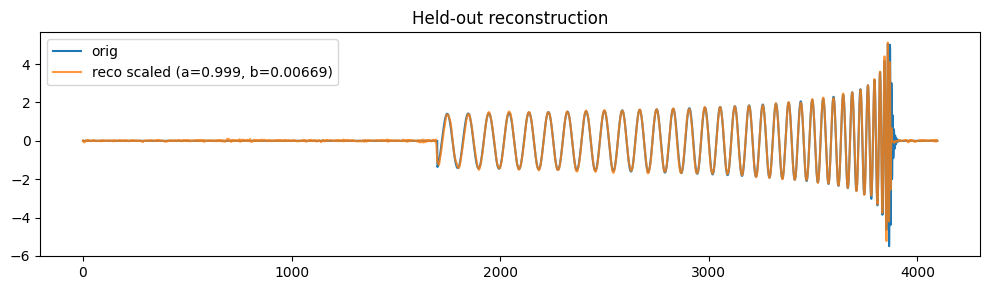

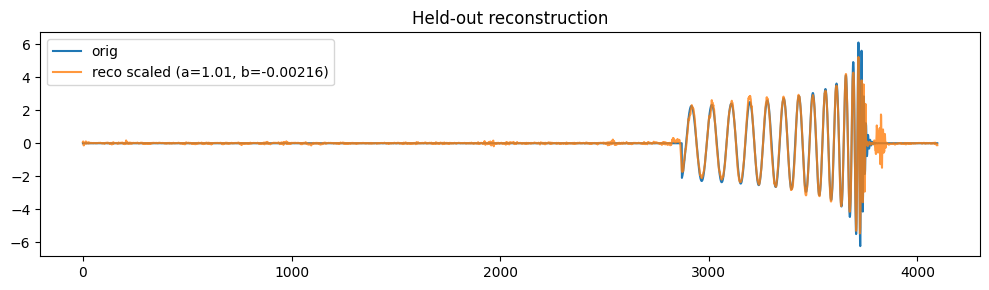

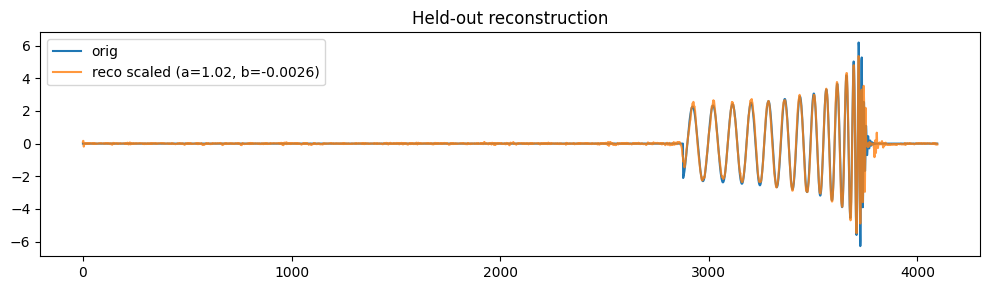

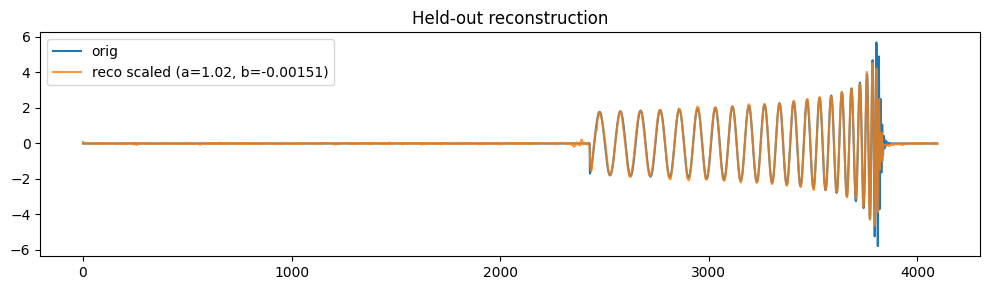

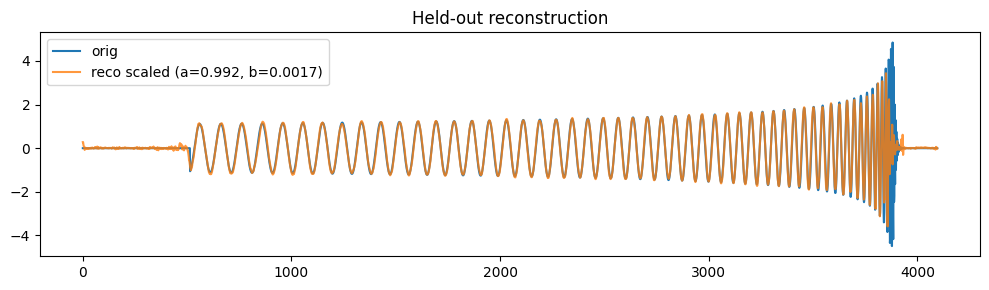

In [24]:

def plot_examples(model, X_test: np.ndarray, n: int = 5, start: int = 0):
    model.eval()
    n = min(n, len(X_test)-start)
    x = torch.from_numpy(X_test[start:start+n]).unsqueeze(1).to(device)
    with torch.no_grad():
        xh,_,_ = model(x)
    xo = x.squeeze(1).cpu().numpy()
    xr = xh.squeeze(1).cpu().numpy()
    for i in range(n):
        # Fit scale/offset for visual alignment (optional)
        A = np.vstack([xr[i], np.ones_like(xr[i])]).T
        a,b = np.linalg.lstsq(A, xo[i], rcond=None)[0]
        xr_fit = a*xr[i] + b
        plt.figure(figsize=(10,3))
        plt.plot(xo[i], label="orig")
        plt.plot(xr_fit, alpha=0.8, label=f"reco scaled (a={a:.3g}, b={b:.3g})")
        plt.title("Held-out reconstruction")
        plt.legend(); plt.tight_layout(); plt.show()

plot_examples(model, X_test, n=5, start=0)


### Latent Sampling

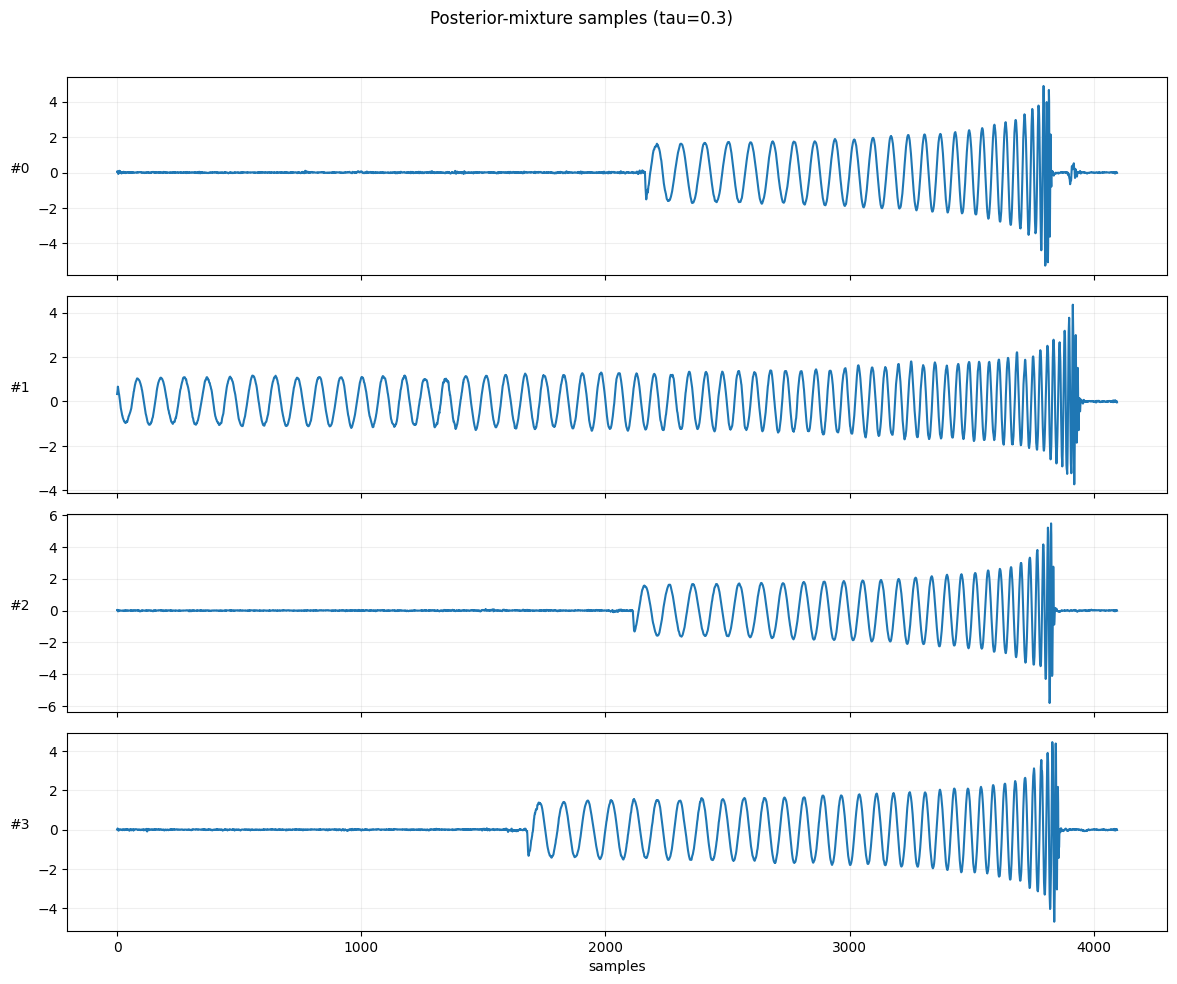

In [36]:
import numpy as np, torch, matplotlib.pyplot as plt

model.eval()
n = 4               # how many to sample
K = min(1024, len(X_train))   # encode a small subset for speed
idx = np.random.choice(len(X_train), size=K, replace=False)
xb  = torch.from_numpy(X_train[idx]).unsqueeze(1).to(device)

with torch.no_grad():
    mu, logvar = model.enc(xb)
    std = torch.exp(0.5 * logvar)
    pick = torch.randint(0, K, (n,), device=device)
    tau  = 0.3                    # temperature: 0.0..1.0 (higher = more diverse)
    z    = mu[pick] + tau * std[pick] * torch.randn_like(std[pick])
    xg   = model.dec(z).cpu().numpy().squeeze(1)

# plot
n = xg.shape[0]
fig, axes = plt.subplots(n, 1, figsize=(12, 2.4 * n), sharex=True)
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    ax.plot(xg[i])
    ax.set_ylabel(f"#{i}", rotation=0, labelpad=12)
    ax.grid(alpha=0.2)

axes[-1].set_xlabel("samples")
fig.suptitle(f"Posterior-mixture samples (tau={tau})", y=1.02)
plt.tight_layout()
plt.show()



### Application to Real Events

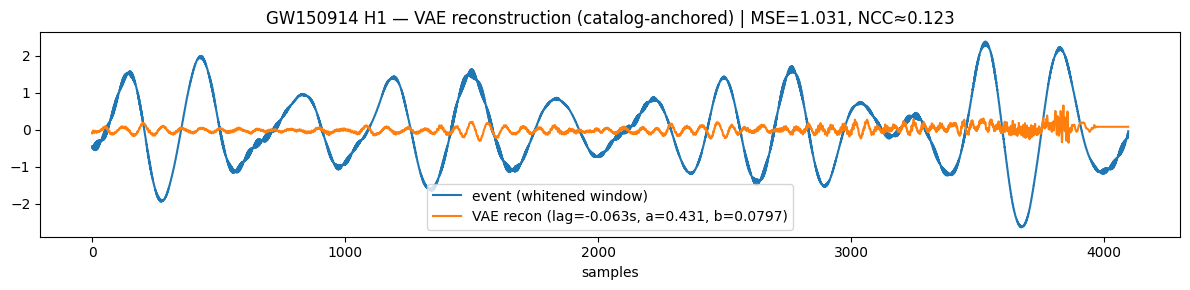

In [52]:
# Catalog-anchored event reconstruction with index-safe window + lag alignment
import numpy as np, torch, matplotlib.pyplot as plt
from fractions import Fraction
from scipy.signal import resample_poly
from pycbc.catalog import Merger
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.psd import welch, interpolate as psd_interpolate

def _resample(x, sr_in, sr_out):
    if sr_in == sr_out: return x.astype(np.float32, copy=False)
    frac = Fraction(sr_out, sr_in).limit_denominator()
    return resample_poly(x, frac.numerator, frac.denominator).astype(np.float32)

def plot_event_reconstruction_aligned(model, cfg, event="GW150914", det="H1",
                                      pad=16.0, end_offset=0.05, align_max_shift=0.25):
    device = next(model.parameters()).device
    model.eval()

    # 1) fetch & clamp strain
    m = Merger(event); evt_time = float(m.time)
    s = m.strain(det)
    lo = max(float(s.start_time), evt_time - pad)
    hi = min(float(s.end_time),   evt_time + pad)
    seg = s.time_slice(lo, hi)

    # 2) Welch PSD -> sanitize -> whiten
    seg32 = TimeSeries(seg.numpy().astype(np.float32), delta_t=seg.delta_t, epoch=seg.start_time)
    fd    = seg32.to_frequencyseries()
    psd   = welch(seg32, seg_len=4, seg_stride=2, avg_method='median')
    psd   = psd_interpolate(psd, float(fd.delta_f)); psd.resize(len(fd))
    ps    = psd.numpy()
    good  = np.isfinite(ps) & (ps > 0)
    floor = max(1e-30, np.percentile(ps[good], 5)) if good.any() else 1e-30
    ps    = np.clip(ps, floor, 1e10).astype(np.float32)
    wfd   = FrequencySeries((fd.numpy().astype(np.complex64) / np.sqrt(ps)).astype(np.complex64),
                            delta_f=fd.delta_f)
    w     = wfd.to_timeseries()

    # 3) INDEX-BASED window anchored at catalog time (never out of bounds)
    sr_data = int(round(1.0 / w.delta_t))
    W       = w.numpy().astype(np.float32)
    N       = len(W)
    T_smpl  = int(round(cfg.DUR * sr_data))

    k_evt   = int(round((evt_time - float(w.start_time)) * sr_data))
    k_end   = min(N, max(0, k_evt + int(round(end_offset * sr_data))))
    k_beg   = max(0, k_end - T_smpl)
    win     = W[k_beg:k_end]
    if len(win) == 0:                                  # last fallback
        win = W[max(0, N - T_smpl):N]

    # 4) resample to model SR, force exact T, z-score
    x_rs = _resample(win, sr_data, cfg.SR)
    T = int(cfg.SR * cfg.DUR)
    x_rs = np.pad(x_rs, (max(0, T - len(x_rs)), 0))[-T:]
    x_in = (x_rs - x_rs.mean()) / (x_rs.std() + 1e-6)

    # 5) encode -> decode
    with torch.no_grad():
        xt = torch.from_numpy(x_in).view(1,1,-1).to(device)
        x_hat, _, _ = model(xt)
        xr = x_hat.squeeze().cpu().numpy().astype(np.float32)

    # 6) small time-lag search (±align_max_shift) + affine fit
    maxlag = int(round(align_max_shift * cfg.SR))
    a0 = (x_in - x_in.mean()) / (x_in.std() + 1e-6)
    b0 = (xr   - xr.mean())   / (xr.std()   + 1e-6)
    best_lag, best_ncc = 0, -np.inf
    for L in range(-maxlag, maxlag+1):
        if L >= 0: u, v = a0[L:], b0[:len(a0)-L]
        else:      u, v = a0[:len(a0)+L], b0[-L:]
        if len(u) < T//2: continue
        ncc = float(np.dot(u, v) / len(u))
        if ncc > best_ncc: best_ncc, best_lag = ncc, L
    if best_lag >= 0: xr_shift = np.pad(xr, (best_lag, 0))[:T]
    else:             xr_shift = np.pad(xr[-best_lag:], (0, -best_lag))[:T]

    A = np.vstack([xr_shift, np.ones_like(xr_shift)]).T
    a, b = np.linalg.lstsq(A, x_in, rcond=None)[0]
    xr_fit = a * xr_shift + b
    mse = float(np.mean((xr_shift - x_in)**2))

    # 7) plot
    plt.figure(figsize=(12,3))
    plt.plot(x_in,  label="event (whitened window)")
    plt.plot(xr_fit, label=f"VAE recon (lag={best_lag/cfg.SR:.3f}s, a={a:.3g}, b={b:.3g})")
    plt.title(f"{event} {det} — VAE reconstruction (catalog-anchored) | MSE={mse:.3f}, NCC≈{best_ncc:.3f}")
    plt.xlabel("samples"); plt.legend(); plt.tight_layout(); plt.show()

# usage:
plot_event_reconstruction_aligned(model, cfg, event="GW150914", det="H1")
